# Using load_ard to load and cloud mask multiple satellite sensors <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations from either multiple Landsat (i.e. Landsat 5, 7 and 8) or Sentinel-2 satellites (i.e. S2A and S2B).
The function automatically applies cloud masking to the input data and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality, non-cloudy or shadowed pixels.
This can be used to extract visually appealing time series of observations that are not affected by cloud.

This notebook demonstrates how to use `load_ard` to:

1. Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
2. Optionally apply a cloud mask to the resulting data
3. Filter resulting data to keep only cloud-free observations
4. Load and combine Sentinel-2A and Sentinel-2B data into a single `xarray.Dataset`
5. Optionally label resulting data with metadata indicating the satellite sensor the data came from
6. Lazily load data using Dask

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import sys

sys.path.append('../Scripts')
from dea_datahandling import load_ard

%load_ext autoreload
%autoreload 2


### Connect to the datacube


In [2]:
# Connect to datacube containing Sentinel 2 data
dc_sentinel2 = datacube.Datacube(app='Using_load_ard')

# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Using_load_ard', env='c3-samples')
except:
    dc_landsat = datacube.Datacube(app='Using_load_ard')


## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple `DEA` products or satellite sensors. 
At its simplest, you can use the function similarly to `dc.load` by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the dc.load documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that `load_ard` also requires an existing `Datacube` object, which is passed using the `dc` parameter. 
This gives us the flexibilty to load data from development or experimental datacubes.

In the examples below, we load a single band of data (`nbart_green`) from the three Landsat Collection 3 products (Landsat 5, 7 and 8) by specifying: `products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']`.
The function always outputs the number of observations for each product, and the total number loaded.
For the following examples, the function output shows that 0 Landsat 5 observations, 11 Landsat 7 observations, and 12 Landsat 8 observations were loaded, for a combined total of 23 observations.

### Explicit syntax
The following example demonstrates how key parameters can be passed directly to `load_ard`.

In [3]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_landsat,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              x=(153.38, 153.47),
              y=(-28.83, -28.92),
              time=('2018-04', '2018-06'),
              measurements=['nbart_green'],
              output_crs='EPSG:3577',
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
print(ds)


Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 16 observations 
<xarray.Dataset>
Dimensions:      (time: 16, x: 342, y: 380)
Coordinates:
  * x            (x) float64 2.05e+06 2.051e+06 ... 2.061e+06 2.061e+06
  * y            (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * time         (time) datetime64[ns] 2018-04-01T23:43:28.557464 ... 2018-06-28T23:41:33.464057
Data variables:
    nbart_green  (time, y, x) float32 nan nan nan nan ... 559.0 405.0 395.0
Attributes:
    crs:      EPSG:3577


In [13]:
ds[['fmask' | 're']]

TypeError: unsupported operand type(s) for |: 'str' and 'str'

### Query syntax
The following example demonstrates how key parameters can be stored in a `query` dictionary, to be passed as a single parameter to `load_ard`.
The `query` can then be reused in other `load_ard` calls.

In [4]:
# Create a reusable query
query = {
    'x': (153.38, 153.47),
    'y': (-28.83, -28.92),
    'time': ('2018-04', '2018-06'),
    'measurements': ['nbart_green'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_landsat, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              **query)

# Print output data
print(ds)


Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 16 observations 
<xarray.Dataset>
Dimensions:      (time: 16, x: 342, y: 380)
Coordinates:
  * x            (x) float64 2.05e+06 2.051e+06 ... 2.061e+06 2.061e+06
  * y            (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * time         (time) datetime64[ns] 2018-04-01T23:43:28.557464 ... 2018-06-28T23:41:33.464057
Data variables:
    nbart_green  (time, y, x) float32 nan nan nan nan ... 559.0 405.0 395.0
Attributes:
    crs:      EPSG:3577


### Working with cloud masking
By plotting a time slice from the data we loaded above, you can see an area of white pixels where clouds have been masked out and set to `NaN`:

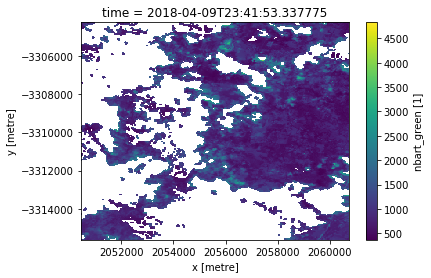

In [5]:
# Plot single observation
ds.isel(time=1).nbart_green.plot()
plt.show()


By default, `load_ard` applies a pixel quality mask to loaded data using the `fmask` band. 
The default mask is created based on `fmask` values `[1, 4, 5]` which will preserve non-cloudy or shadowed land, snow and water pixels, and set all invalid, cloudy or shadowy pixels to `NaN`. 
This can be customised using the `fmask_gooddata` parameter.
To deactive cloud masking completely, set `mask_pixel_quality=False`:

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls8c_ard_3 data
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 16 observations 


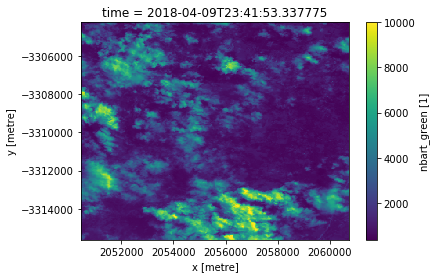

In [6]:
# Load available data with cloud masking deactivated
ds = load_ard(dc=dc_landsat, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              mask_pixel_quality=False, 
              **query)

# Plot single observation
ds.isel(time=1).nbart_green.plot()
plt.show()


### Filtering to non-cloudy observations
In addition to masking out cloud, `load_ard` allows you to discard any satellite observation that contains less than a minimum proportion of good quality (e.g. non-cloudy) pixels.
This can be used to obtain a time series of only clear, cloud-free observations.

To discard all observations with less than `X`% good quality pixels, use the `min_gooddata` parameter. 
For example, `min_gooddata=0.99` will return only observations where less than 1% of pixels contain cloud, cloud shadow or other invalid data, resulting in a smaller number of clear, cloud free images being returned by the function:

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 0 out of 5 observations
    No data for ga_ls7e_ard_3
Loading ga_ls8c_ard_3 data
    Filtering to 2 out of 11 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 2 observations 


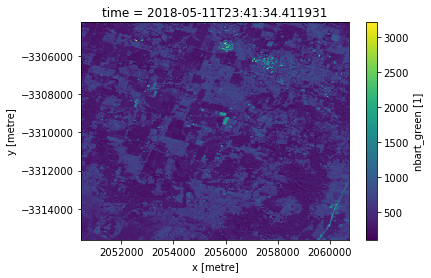

In [7]:
# Load available data filtered to 99% clear observations
ds_noclouds = load_ard(dc=dc_landsat,
                       products=['ga_ls5t_ard_3', 
                                 'ga_ls7e_ard_3', 
                                 'ga_ls8c_ard_3'],
                       min_gooddata=0.99,
                       **query)

# Plot single observation
ds_noclouds.isel(time=0).nbart_green.plot()
plt.show()

### Discarding Landsat 7 SLC-off failure data
On [May 31 2003, Landsat 7's Scan Line Corrector (SLC) that compensated for the satellite's forward motion failed](http://usgs.gov/land-resources/nli/landsat/landsat-7), introducing linear data gaps in all subsequent Landsat 7 observations. 
For example, the following Landsat 7 image contains visible striping:

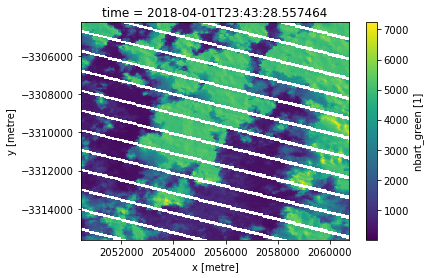

In [8]:
# Plot Landsat data
ds.isel(time=0).nbart_green.plot()

Although this data still contains valuable information, for some applications (e.g. generating clean composites from multiple images) it can be useful to discard Landsat 7 imagery acquired after the SLC failure.
This data is known as "SLC-off" data.

This can be achieved using `load_ard` using the `ls7_slc_off`. 
By default this is set to `ls7_slc_off=True` which will include all SLC-off data.
Set to `ls7_slc_off=False` to discard this data instead; observe that the function reports that `No data for ga_ls7e_ard_3`, because all Landsat 7 observations were made after the May 31 2003 SLC failure.

In [9]:
# Load available data after discarding Landsat 7 SLC-off data
ds = load_ard(dc=dc_landsat, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              ls7_slc_off=False,
              **query)

# Print output data
print(ds)

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    No data for ga_ls7e_ard_3
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 11 observations 
<xarray.Dataset>
Dimensions:              (time: 11, x: 342, y: 380)
Coordinates:
  * x                    (x) float64 2.05e+06 2.051e+06 ... 2.061e+06 2.061e+06
  * y                    (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06
  * time                 (time) datetime64[ns] 2018-04-09T23:41:53.337775 ... 2018-06-28T23:41:33.464057
Data variables:
    nbart_green          (time, y, x) float32 774.0 815.0 901.0 ... 405.0 395.0
    fmask                (time, y, x) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 5.0
    oa_nbart_contiguity  (time, y, x) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577


## Loading Sentinel-2 data
Data from the Sentinel-2A and Sentinel-2B satellites can also be loaded using `load_ard`. 
To do this, we need to specify the two Sentinel-2 products (`['s2a_ard_granule', 's2b_ard_granule']`) in place of the Landsat products above.
The `query` parameter can be reused to load Sentinel-2 data for the same specifcations used for the Landsat data above:

In [10]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              **query)

# Print output data
print(ds)


Loading s2a_ard_granule data


ValueError: Band 'oa_nbart_contiguity' does not exist in this product. Verify all requested `measurements` exist in ['s2a_ard_granule', 's2b_ard_granule']

Cloudy pixels are masked out by default from the resulting observations similarly to Landsat:

In [ ]:
# Plot single observation
ds.isel(time=3).nbart_green.plot()
plt.show()


### Keeping track of sensor information
Because `load_ard` combines multiple sensors/products into a single `xarray.Dataset`, it can be important to keep track of what satellite made each observation. Setting `product_metadata=True` will add a new `product` variable to the output that labels each observation with its product name:

In [ ]:
# Load available Sentinel 2 data, adding product metadata
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              product_metadata=True,
              **query)

# Print output data
print(ds)


## Lazy loading with Dask

Rather than load data directly - which can take a long time and large amounts of memory - all datacube data can be lazy loaded using `Dask`.
This can be a very useful approach for when you need to load large amounts of data without crashing your analysis, or if you want to subsequently scale your analysis by distributing tasks in parallel across multiple workers. 

The `load_ard` function can be easily adapted to lazily load data rather than loading it into memory by providing a `dask_chunks` parameter using either the [explicit](#Explicit-syntax) or [query](#Query-syntax) syntax.
The minimum required to lazily load data is `dask_chunks={}`, but chunking can also be performed spatially (e.g. `dask_chunks={'x': 1000, 'y': 1000}`) or by time (e.g. `dask_chunks={'time': 1}`) depending on the analysis being conducted.

In [ ]:
# Lazily load available Sentinel 2 data
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              dask_chunks={},
              **query)

# Print output data
print(ds)

Note that the data loads almost instantaneously, and that that each of the arrays listed under `Data variables` are now described as `dask.arrays`.
To load the data into memory, you can simply run:

In [ ]:
ds.compute()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)